In [14]:
# Basisc square wave: SX-->T1;  flat band --> T2;  T1 + T2 = T
from scipy.special import jn_zeros
from itertools import combinations


def zerodrive(t, args):
    d = args['duty']
    w = args['omega']
    T = 2 * np.pi/w
    sqr = -signal.square(w * t, duty = d)
    if sqr < 0:
        sqr= 0
    return sqr

def onedrive(t, args):
    d = args['duty']
    w = args['omega']
    T = 2 * np.pi/w
    sqr = signal.square(w * t, duty = d)
    if sqr < 0:
        sqr= 0
    return sqr

def drive1(t, args):
    d = args['duty']
    w = args['omega']
    J = args['J']
    T = 2 * np.pi/w
    sqr = J * signal.square(w * t, duty = d)
    return sqr

def drive2(t, args):
    d = args['duty']
    w = args['omega']
    g = args['g']
    T = 2 * np.pi/w
    sqr = g * signal.square(2 * w * t, duty = d)
    return sqr

def drive3(t, args):
    d = args['duty']
    w = args['omega']
    lambda_s = args['lambda_s']
    T = 2 * np.pi/w
    sqr = - lambda_s * signal.square(w * t, duty = d) 
    if sqr < 0:
        sqr= 0
    return sqr


# HAMILTONIAN   

def j_ij(Jvalue, i,j, beta):
    return Jvalue/(np.abs(i-j))**beta
 
def position_hamiltonian(args):
    N  =  args['N']
    er = args['er']
    sx,sy,sz = sigmax(), sigmay(), sigmaz()
    empt = qzero(2**N) + 1j * qzero(2**N)    
    H01, H02, H11, H31 = empt,  empt, empt, empt
    
    for i in range(N-1):
        id = qeye(2**i)    
        dim11 = N-2-i
        id1 = qeye(2**dim11)
        H01 = H01 + Qobj(tensor(id,tensor(sz,tensor(sz,id1))).full())

    for i in range(N):
        id = qeye(2 ** i)    
        dim11 = N-1-i
        id1 = qeye(2 ** dim11)
        H02 = H02 + Qobj(tensor(id,tensor(sx,id1)).full())
        
    for i in range(N):
        id = qeye(2**i)    
        dim11 = N-1-i
        id1 = qeye(2**dim11)
        H11 = H11 + Qobj(tensor(id,tensor(sx,id1)).full()) * (1-er)
        
        
    for i in range(N):
        id = qeye(2**i)    
        dim11 = N-1-i
        id1 = qeye(2**dim11)
        H31 = H31 + Qobj(tensor(id,tensor(sz,id1)).full())

    return H01, H02, H11, H31

# FLOQUET ANALYSIS

def floquet_return_position(args):
    N  =  args['N']
    er = args['er']
    H01, H02, H11, H31 = position_hamiltonian(args)
    H = [[H01, drive1],[H02,drive2],[H11,drive3]]

    T = 2 * np.pi/args['omega']
    f_modes_0, f_energies = floquet_modes(H, T, args)
    return f_energies

# MAGNETIZATION
def magnetization_position(args):      
    N  =  args['N']
    er = args['er']
    H01, H02, H11, H31 = position_hamiltonian(args)
    H = [[H01, drive1],[H02,drive2],[H11,drive3]]

    grket = basis(2**N,0)
    times = args['times']
    data = mesolve(H, grket, times, [], [H31/N], args = args)
    return data.expect

print("Functions defined")

Functions defined


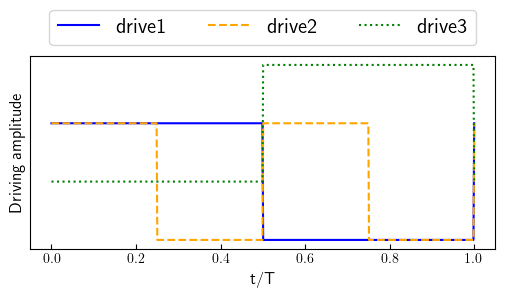

In [18]:
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
from scipy.special import jn_zeros


plt.rcParams.update({"figure.figsize": (6, 2.5), "text.usetex": True, "font.size": 20})

w = 4
T = 2 * np.pi/w
h = jn_zeros(0,1)[0] * w/4
times = np.linspace(0, 1*T, 600)
duty = 0.5

J = 1
g = 1

params = {'omega': w, 'duty': duty, 'lambda_s': w/2, 'lambda_0': h,\
    'omega_0': 0, 'omega_1': 0.5, 'h':h, 'J': J , 'g': g}  

plt.plot(times/T, np.array([drive1(t, params) for t in times]), color = 'blue', label = r'drive1')
plt.plot(times/T, np.array([drive2(t, params) for t in times]), color = 'orange', label = r'drive2', ls= '--')
plt.plot(times/T, np.array([drive3(t, params) for t in times]), color = 'green', label = r'drive3', ls= ':')

plt.tick_params(axis='both', which='both', labelsize=10)
plt.xlabel('t/T', fontsize = 12)
plt.ylabel(r'Driving amplitude', fontsize = 12)
plt.tick_params(which='both', direction='in')
plt.legend(frameon = True,  fontsize =15, ncol =3, loc = 'center', bbox_to_anchor = (0.5, 1.15))
plt.yticks([])
#plt.ylim(-1.1, 1.6)
#plt.savefig("ising_freezing_dtc_drive.pdf", bbox_inches = 'tight')

plt.show()

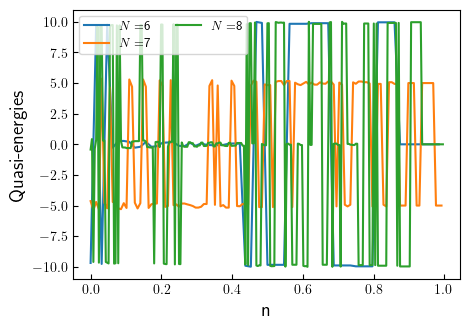

In [19]:
import matplotlib.pyplot as plt
import traceback
import numpy as np
from qutip import *
from scipy import signal
import h5py
from multiprocessing import Pool

Ns = [6, 7, 8]
omega = 20
w = omega
h = jn_zeros(0,1)[0] * w/4
duty = 0.5

lambda_s = w/(4*duty)
J = 0.18
g = J/2
er = 0.0

T = 2 * np.pi/omega
time_period = 10
times = np.linspace(0, time_period * T, time_period * 50 +1, endpoint = True)

nprocs = len(Ns)
p = Pool(processes = nprocs) 
opts = Options(nsteps=1e4, num_cpus=1, openmp_threads=1)

params = [{'omega':omega,'er':er, 'lambda_s':w/(4*duty),'h':h,\
            'times':times, 'N':N, 'duty':duty,'J':J, 'g':g} for N in Ns]

data_floquet = p.map(floquet_return_position, params)

#-------------------------------------------------------
#       Now Plot the data
#-------------------------------------------------------

plt.rcParams.update({"figure.figsize": (5, 3.5), "text.usetex": True, "font.size": 14})

T = 2 * np.pi/omega

for i, N in enumerate(Ns):
    plt.plot(np.linspace(0, len(data_floquet[i])-1, len(data_floquet[i]))/len(data_floquet[i]), data_floquet[i], label = r'$N=$'+str(N))

plt.xlabel('n')
plt.ylabel(r'Quasi-energies')
plt.tick_params(axis='both', which='both', labelsize=10)
plt.tick_params(which='both', direction='in')
plt.legend(frameon = True,  fontsize =9, ncol = 2)
#plt.xlim(1490, 1500)
#plt.ylim(0.95, 1.02)

#plt.axhline(y = 1, color = 'black', lw = 0.5)
#plt.axhline(y = -0.5, color = 'black', lw = 0.5)

#plt.savefig("ising_freezing_dtc_magnetization.pdf", bbox_inches = 'tight')
plt.show()

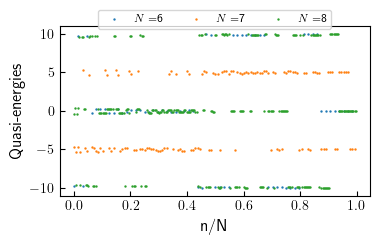

In [20]:
plt.rcParams.update({"figure.figsize": (4, 2.2), "text.usetex": True, "font.size": 12})

T = 2 * np.pi/omega

for i, N in enumerate(Ns):
    #plt.scatter(range(len(data_floquet[i])), data_floquet[i], s = 0.3, label = r'$N=$'+str(N))
    plt.scatter(np.linspace(0, len(data_floquet[i])-1, len(data_floquet[i]))/len(data_floquet[i]), data_floquet[i], s= 0.5, label = r'$N=$'+str(N))
    
plt.xlabel('n/N')
plt.ylabel(r'Quasi-energies')
plt.tick_params(axis='both', which='both', labelsize=10)
plt.tick_params(which='both', direction='in')
plt.legend(frameon=True, fontsize=8, ncol=5, loc='upper center', bbox_to_anchor=(0.5, 1.13))
#plt.xlim(1490, 1500)
#plt.ylim(0.95, 1.02)

#plt.axhline(y = 1, color = 'black', lw = 0.5)
#plt.axhline(y = -0.5, color = 'black', lw = 0.5)

#plt.savefig("ising_freezing_dtc_magnetization.pdf", bbox_inches = 'tight')

plt.show()

### Time evolution of Magnetization

In [23]:
# Basisc square wave: SX-->T1;  flat band --> T2;  T1 + T2 = T
from scipy.special import jn_zeros
from itertools import combinations


def zerodrive(t, args):
    d = args['duty']
    w = args['omega']
    T = 2 * np.pi/w
    sqr = -signal.square(w * t, duty = d)
    if sqr < 0:
        sqr= 0
    return sqr

def onedrive(t, args):
    d = args['duty']
    w = args['omega']
    T = 2 * np.pi/w
    sqr = signal.square(w * t, duty = d)
    if sqr < 0:
        sqr= 0
    return sqr

def drive1(t, args):
    d = args['duty']
    w = args['omega']
    J = args['J']
    T = 2 * np.pi/w
    sqr = J * signal.square(w * t, duty = d)
    return sqr

def drive2(t, args):
    d = args['duty']
    w = args['omega']
    g = args['g']
    T = 2 * np.pi/w
    sqr = g * signal.square(2 * w * t, duty = d)
    return sqr

def drive3(t, args):
    d = args['duty']
    w = args['omega']
    lambda_s = args['lambda_s']
    T = 2 * np.pi/w
    sqr = - lambda_s * signal.square(w * t, duty = d) 
    if sqr < 0:
        sqr= 0
    return sqr


# HAMILTONIAN   

def j_ij(Jvalue, i,j, beta):
    return Jvalue/(np.abs(i-j))**beta
 
def position_hamiltonian(args):
    N  =  args['N']
    er = args['er']
    sx,sy,sz = sigmax(), sigmay(), sigmaz()
    empt = qzero(2**N) + 1j * qzero(2**N)    
    H01, H02, H11, H31 = empt,  empt, empt, empt
    
    for i in range(N-1):
        id = qeye(2**i)    
        dim11 = N-2-i
        id1 = qeye(2**dim11)
        H01 = H01 + Qobj(tensor(id,tensor(sz,tensor(sz,id1))).full())

    for i in range(N):
        id = qeye(2 ** i)    
        dim11 = N-1-i
        id1 = qeye(2 ** dim11)
        H02 = H02 + Qobj(tensor(id,tensor(sx,id1)).full())
        
    for i in range(N):
        id = qeye(2**i)    
        dim11 = N-1-i
        id1 = qeye(2**dim11)
        H11 = H11 + Qobj(tensor(id,tensor(sx,id1)).full()) * (1-er)
        
        
    for i in range(N):
        id = qeye(2**i)    
        dim11 = N-1-i
        id1 = qeye(2**dim11)
        H31 = H31 + Qobj(tensor(id,tensor(sz,id1)).full())

    return H01, H02, H11, H31

# FLOQUET ANALYSIS

def floquet_return_position(args):
    N  =  args['N']
    er = args['er']
    H01, H02, H11, H31 = position_hamiltonian(args)
    H = [[H01, drive1],[H02,drive2],[H11,drive3]]

    T = 2 * np.pi/args['omega']
    f_modes_0, f_energies = floquet_modes(H, T, args)
    return f_energies

# MAGNETIZATION
def magnetization_position(args):      
    N  =  args['N']
    er = args['er']
    H01, H02, H11, H31 = position_hamiltonian(args)
    H = [[H01, drive1],[H02,drive2],[H11,drive3]]

    grket = basis(2**N,0)
    times = args['times']
    data = mesolve(H, grket, times, [], [H31/N], args = args)
    return data.expect

print("Functions defined")

Functions defined


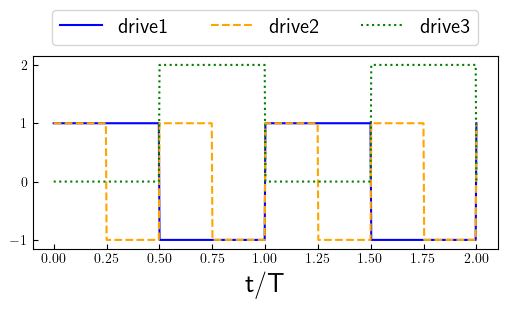

In [26]:
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
from scipy.special import jn_zeros


plt.rcParams.update({"figure.figsize": (6, 2.5), "text.usetex": True, "font.size": 20})

w = 4
T = 2 * np.pi/w
h = jn_zeros(0,1)[0] * w/4
times = np.linspace(0, 2*T, 600)
duty = 0.5

J = 1
g = 1

params = {'omega': w, 'duty': duty, 'lambda_s': w/2, 'lambda_0': h, 'omega_0': 0, 'omega_1': 0.5, 'h':h, 'J': J , 'g': g}  

plt.plot(times/T, np.array([drive1(t, params) for t in times]), color = 'blue', label = r'drive1')
plt.plot(times/T, np.array([drive2(t, params) for t in times]), color = 'orange', label = r'drive2', ls= '--')
plt.plot(times/T, np.array([drive3(t, params) for t in times]), color = 'green', label = r'drive3', ls= ':')

plt.tick_params(axis='both', which='both', labelsize=10)
plt.xlabel('t/T')
plt.tick_params(which='both', direction='in')
plt.legend(frameon = True,  fontsize =15, ncol =3, loc = 'center', bbox_to_anchor = (0.5, 1.15))

#plt.ylim(-1.1, 1.6)
#plt.savefig("ising_freezing_dtc_drive.pdf", bbox_inches = 'tight')

plt.show()


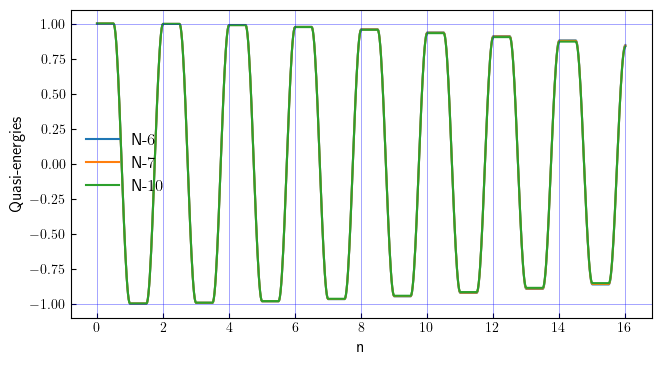

In [30]:
import matplotlib.pyplot as plt
import traceback
import numpy as np
from qutip import *
from scipy import signal
import h5py
from multiprocessing import Pool

plt.rcParams.update({"figure.figsize": (7.5,4), "text.usetex": True, "font.size": 12})

Ns = [6, 7, 10]
omega = 20
w = omega
h = jn_zeros(0,1)[0] * w/4
duty = 0.5

lambda_s = w/(4*duty)
J = 0.18
g = J/2
er = 0.0

T = 2 * np.pi/omega
time_period = 16
times = np.linspace(0, time_period * T, time_period * 50 +1, endpoint = True)

nprocs = len(Ns)
p = Pool(processes = nprocs) 
opts = Options(nsteps=1e4, num_cpus=1, openmp_threads=1)

params = [{'omega':omega,'er':er, 'lambda_s':w/(4*duty),'h':h,\
            'times':times, 'N':N, 'duty':duty,'J':J, 'g':g} for N in Ns]

data_tfim_p_fb = np.array(p.map(magnetization_position, params))

# DATA PLOTTING

for i, N in enumerate(Ns):
    plt.plot(times/T, data_tfim_p_fb[i][0], label =fr"N-${N}$")

plt.xlabel('n')
plt.ylabel(r'Quasi-energies')
plt.tick_params(axis='both', which='both', labelsize=10)
plt.tick_params(which='both', direction='in')
plt.legend(frameon = False,  fontsize =12)
#plt.xlim(1490, 1500)
#plt.ylim(0.99, 1.01)

plt.axhline(y = 1,  color = 'blue', alpha = 0.5, lw = 0.5)
plt.axhline(y = -1, color = 'blue', alpha = 0.5, lw = 0.5)

for i in np.arange(0, int(times[-1]/T)+1, 2):
    plt.axvline(x = i, color = 'blue', alpha = 0.5, lw = 0.5)

#plt.savefig("ising_freezing_dtc_magnetization.pdf", bbox_inches = 'tight')

plt.show()


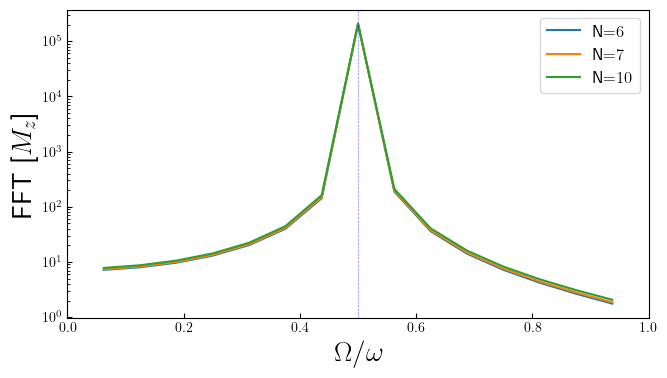

In [31]:
# FFT of each magnetization data
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from scipy.signal import find_peaks


plt.rcParams.update({"figure.figsize": (7.5, 4), "text.usetex": True, "font.size": 20})
from scipy.fft import fft, ifft, fftfreq

N = data_tfim_p_fb.shape[1]
T = 2 * np.pi/omega

freq_threshold = 0.01

for i, N in enumerate(Ns):    
    mz = data_tfim_p_fb[i][0]
    frequencies = T * np.fft.fftfreq(mz.size, d = times[-1]/len(times))
    fft_values = np.fft.fft(mz - np.average(mz))            
    mask = (frequencies > freq_threshold) & (frequencies <0.95)
    y = np.abs(fft_values[mask])**2
    x = frequencies[mask]       
    peak_idx, peak_props = find_peaks(y, prominence = 1)
    peak_pos = x[peak_idx]  

    plt.plot(x,y, label = rf"N=${N}$")
plt.xlim(0, 1)
plt.yscale('log')
plt.xlabel(r'$\Omega/\omega$')
plt.ylabel(r'FFT [$M_{z}$]')
plt.tick_params(axis='both', which='both', labelsize=10)
plt.tick_params(which='both', direction='in')
plt.legend(frameon = True,  fontsize =12)

plt.axvline(x = 0.5, color = 'blue', alpha = 0.5, lw = 0.5, ls = '--')  

#plt.savefig("ising_freezing_dtc_fft_magnetization.pdf", bbox_inches = 'tight')
plt.show()

In [ ]:
# Basisc square wave: SX-->T1;  flat band --> T2;  T1 + T2 = T
from scipy.special import jn_zeros
from itertools import combinations


def zerodrive(t, args):
    d = args['duty']
    w = args['omega']
    T = 2 * np.pi/w
    sqr = -signal.square(w * t, duty = d)
    if sqr < 0:
        sqr= 0
    return sqr

def onedrive(t, args):
    d = args['duty']
    w = args['omega']
    T = 2 * np.pi/w
    sqr = signal.square(w * t, duty = d)
    if sqr < 0:
        sqr= 0
    return sqr

def drive1(t, args):
    d = args['duty']
    w = args['omega']
    J = args['J']
    T = 2 * np.pi/w
    sqr = J * signal.square(w * t, duty = d)
    return sqr

def drive2(t, args):
    d = args['duty']
    w = args['omega']
    g = args['g']
    T = 2 * np.pi/w
    sqr = g * signal.square(2 * w * t, duty = d)
    return sqr

def drive3(t, args):
    d = args['duty']
    w = args['omega']
    lambda_s = args['lambda_s']
    T = 2 * np.pi/w
    sqr = - lambda_s * signal.square(w * t, duty = d) 
    if sqr < 0:
        sqr= 0
    return sqr

# HAMILTONIAN   

def j_ij(Jvalue, i,j, beta):
    return Jvalue/(np.abs(i-j))**beta
 
def position_hamiltonian(args):
    N  =  args['N']
    er = args['er']
    Jvalue = args['Jvalue']
    sx,sy,sz = sigmax(), sigmay(), sigmaz()
    empt = qzero(2**N) + 1j * qzero(2**N)    
    H01, H02, H11, H21, H30 = empt,  empt, empt, empt, empt
    
    for i in range(N-1):
        id = qeye(2**i)    
        dim11 = N-2-i
        id1 = qeye(2**dim11)
        H01 = H01 + Qobj(tensor(id,tensor(sz,tensor(sz,id1))).full())

    for i in range(N):
        id = qeye(2 ** i)    
        dim11 = N-1-i
        id1 = qeye(2 ** dim11)
        H02 = H02 + Qobj(tensor(id,tensor(sx,id1)).full())
        
    for i in range(N):
        id = qeye(2**i)    
        dim11 = N-1-i
        id1 = qeye(2**dim11)
        H11 = H11 + Qobj(tensor(id,tensor(sx,id1)).full()) * (1-er)
        
    comb = combinations(np.arange(N), 2)
    for nm in list(comb):
        i,j= np.array(nm)
        id = qeye(2**i)
        dim11 = j-i-1
        id1 = qeye(2**dim11)
        dim12 = N-1-j
        id2 = qeye(2**dim12)
        H21 = H21 + Qobj(tensor(id, tensor(sz, tensor(id1, tensor(sz,id2)))).full()) * j_ij(Jvalue, i,j, beta)

    for i in range(N):
        id = qeye(2 ** i)    
        dim11 = N-1-i
        id1 = qeye(2 ** dim11)
        H30 = H30 + Qobj(tensor(id,tensor(sz,id1)).full())

    return H01, H02, H11, H21, H30

# FLOQUET ANALYSIS

def floquet_return_position(args):
    N  =  args['N']
    er = args['er']
    H01, H02, H11, H21, H30 = position_hamiltonian(args )
    H = [[H01, drive1],[H02,drive2],[H11, drive3]]

    T = 2 * np.pi/args['omega']
    f_modes_0, f_energies = floquet_modes(H, T, args)
    return f_energies

# MAGNETIZATION
def magnetization_position(args):      
    N  =  args['N']
    er = args['er']
    H01, H02, H11, H21, H30 = position_hamiltonian(args )
    H = [[H01, drive1],[H02,drive2],[H11, drive3]]

    grket = basis(2**N,0)
    times = args['times']
    data = mesolve(H, grket, times, [], [H30/N], args = args)
    return data.expect

print("Functions defined")

Functions defined


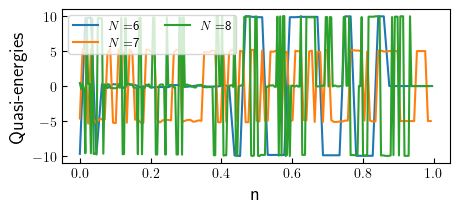

In [17]:
import matplotlib.pyplot as plt
import traceback
import numpy as np
from qutip import *
from scipy import signal
import h5py
from multiprocessing import Pool
plt.rcParams.update({"figure.figsize": (5, 2), "text.usetex": True, "font.size": 14})

Ns = [6, 7, 8]
omega = 20
w = omega
h = jn_zeros(0,1)[0] * w/4
duty = 0.5

lambda_s = w/(4*duty)
J = 0.18
g = J/2
er = 0.0
beta = 0.0

T = 2 * np.pi/omega
time_period = 10
times = np.linspace(0, time_period * T, time_period * 50 +1, endpoint = True)

nprocs = len(Ns)
p = Pool(processes = nprocs) 
opts = Options(nsteps=1e4, num_cpus=1, openmp_threads=1)

params = [{'omega':omega,'er':er, 'lambda_s':w/(4*duty),'h':h,'Jvalue':J,\
            'times':times, 'N':N, 'beta':beta,'duty':duty,'J':J, 'g':g} for N in Ns]

data_floquet = p.map(floquet_return_position, params)

#-------------------------------------------------------
#       Now Plot the data
#-------------------------------------------------------



T = 2 * np.pi/omega

for i, N in enumerate(Ns):
    plt.plot(np.linspace(0, len(data_floquet[i])-1, len(data_floquet[i]))/len(data_floquet[i]), data_floquet[i], label = r'$N=$'+str(N))

plt.xlabel('n')
plt.ylabel(r'Quasi-energies')
plt.tick_params(axis='both', which='both', labelsize=10)
plt.tick_params(which='both', direction='in')
plt.legend(frameon = True,  fontsize =9, ncol = 2)
#plt.xlim(1490, 1500)
#plt.ylim(0.95, 1.02)

#plt.axhline(y = 1, color = 'black', lw = 0.5)
#plt.axhline(y = -0.5, color = 'black', lw = 0.5)

#plt.savefig("ising_freezing_dtc_magnetization.pdf", bbox_inches = 'tight')

plt.show()

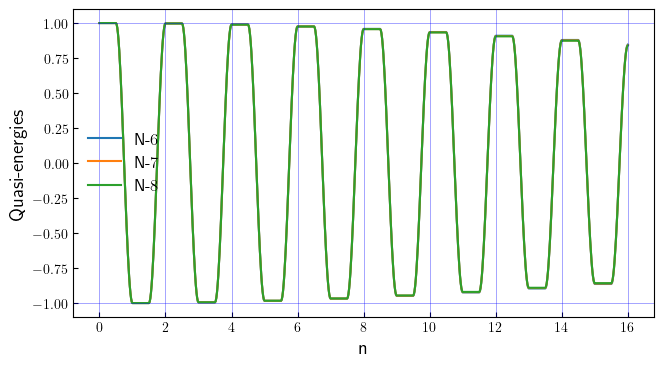

In [19]:
import matplotlib.pyplot as plt
import traceback
import numpy as np
from qutip import *
from scipy import signal
import h5py
from multiprocessing import Pool
plt.rcParams.update({"figure.figsize": (7.5, 4), "text.usetex": True, "font.size": 14})

Ns = [6, 7, 8]
omega = 20
w = omega
h = jn_zeros(0,1)[0] * w/4
duty = 0.5

lambda_s = w/(4*duty)
J = 0.18
g = J/2
er = 0.0
beta = 0.0

T = 2 * np.pi/omega
time_period = 16
times = np.linspace(0, time_period * T, time_period * 50 +1, endpoint = True)

nprocs = len(Ns)
p = Pool(processes = nprocs) 
opts = Options(nsteps=1e4, num_cpus=1, openmp_threads=1)

params = [{'omega':omega,'er':er, 'lambda_s':w/(4*duty),'h':h,'Jvalue':J/5,\
            'times':times, 'N':N, 'beta':beta,'duty':duty,'J':J, 'g':g} for N in Ns]

data_tfim_p_fb = np.array(p.map(magnetization_position, params))

# DATA PLOTTING
for i, N in enumerate(Ns):
    plt.plot(times/T, data_tfim_p_fb[i][0], label =fr"N-${N}$")

plt.xlabel('n')
plt.ylabel(r'Quasi-energies')
plt.tick_params(axis='both', which='both', labelsize=10)
plt.tick_params(which='both', direction='in')
plt.legend(frameon = False,  fontsize =12)
#plt.xlim(1490, 1500)
#plt.ylim(0.99, 1.01)

plt.axhline(y = 1,  color = 'blue', alpha = 0.5, lw = 0.5)
plt.axhline(y = -1, color = 'blue', alpha = 0.5, lw = 0.5)

for i in np.arange(0, int(times[-1]/T)+1, 2):
    plt.axvline(x = i, color = 'blue', alpha = 0.5, lw = 0.5)

#plt.savefig("ising_freezing_dtc_magnetization.pdf", bbox_inches = 'tight')

plt.show()